# Data Exploration and Extraction

In [74]:
import requests
import ast

#url = "https://ethereum-mainnet.core.chainstack.com/75056dfaa3b6113f98bd5d21f478f44d"
url = "https://base-mainnet.core.chainstack.com/2fc1de7f08c0465f6a28e3c355e0cb14/"

payload = {
    "jsonrpc": "2.0",
    "method": "trace_block",
    "id": 1,
    "params": ["0xbb5555"]
}

headers = {
    "accept": "application/json",
    "content-type": "application/json"
}

response = requests.post(url, json=payload, headers=headers)
data = ast.literal_eval(response.text)
print(data['result'])

[{'action': {'from': '0xdeaddeaddeaddeaddeaddeaddeaddeaddead0001', 'callType': 'call', 'gas': '0xeea24', 'input': '0x440a5e200000044d000a118b000000000000000000000000660106df000000000129b055000000000000000000000000000000000000000000000000000000037c18f485000000000000000000000000000000000000000000000000000000000000000105224cd1c874cf06d50b5b2343661867a58d0d06536bbba2571e9e240cca69080000000000000000000000005050f69a9786f081509234f1a7f4684b5e5b76c9', 'to': '0x4200000000000000000000000000000000000015', 'value': '0x0'}, 'blockHash': '0x1e58892ceb83bedadf6302f12a12e8ed130b519b4cdb8a4b3d0109dd5bd2bbca', 'blockNumber': 12277077, 'result': {'gasUsed': '0x73f3', 'output': '0x'}, 'subtraces': 1, 'traceAddress': [], 'transactionHash': '0xe8a4c5576b8306f0f50302985ec3b14cab833418a5c468c7b24fd359cb08bac7', 'transactionPosition': 0, 'type': 'call'}, {'action': {'from': '0x4200000000000000000000000000000000000015', 'callType': 'delegatecall', 'gas': '0xe9b75', 'input': '0x440a5e200000044d000a118b0000000000

In [76]:
d = data['result']
for dat in d:
    try:
        sender = dat['action']['from']
        recipient = dat['action']['to']
        amount = dat['action']['value']
        print(f'From: {sender}\nTo: {recipient}\nAmount: {amount}\n\n')
    except KeyError:
        continue

From: 0xdeaddeaddeaddeaddeaddeaddeaddeaddead0001
To: 0x4200000000000000000000000000000000000015
Amount: 0x0


From: 0x4200000000000000000000000000000000000015
To: 0x07dbe8500fc591d1852b76fee44d5a05e13097ff
Amount: 0x0


From: 0xb62f5290d9a6f35b94c971d28f4ae36ad22e2000
To: 0xb62f5290d9a6f35b94c971d28f4ae36ad22e2000
Amount: 0x221b262dd8000


From: 0x7beca9348b79e545d5f0b8fd178dced98b4d45b2
To: 0xe5abd2089568eb38831355f3680f4ba2c81a22b6
Amount: 0x0


From: 0xe5abd2089568eb38831355f3680f4ba2c81a22b6
To: 0x4200000000000000000000000000000000000006
Amount: 0x0


From: 0xe5abd2089568eb38831355f3680f4ba2c81a22b6
To: 0x4200000000000000000000000000000000000006
Amount: 0x0


From: 0xe5abd2089568eb38831355f3680f4ba2c81a22b6
To: 0x4200000000000000000000000000000000000006
Amount: 0x0


From: 0xe5abd2089568eb38831355f3680f4ba2c81a22b6
To: 0x6ee3a6660ef15db2842f03fa6f50b65d3d49ccce
Amount: 0x0


From: 0x6ee3a6660ef15db2842f03fa6f50b65d3d49ccce
To: 0x4200000000000000000000000000000000000006
Amount: 0x0


In [4]:
start_block_int = 17_500_000
start_block = hex(start_block_int)
end_block_int = 20_344_040
end_block = hex(end_block_int)

str

In [6]:
int("0x1085367", 16)

17322855

In [4]:
def pull_block_data(startblock : str, endblock : str):
    '''
    Pull Ethereum transaction block data

    startblock: hexidecimal string for starting block
    endblock: hexidecimal string for ending block
    '''

    import requests
    import ast
    from tqdm import tqdm
    import gzip
    import pickle

    #start and end block
    startblock_int = int(startblock, 16)
    endblock_int = int(endblock, 16)

    #https url
    url = "https://base-mainnet.core.chainstack.com/2fc1de7f08c0465f6a28e3c355e0cb14/"

    #headers
    headers = {
        "accept": "application/json",
        "content-type": "application/json"
    }
    successful_requests = 0

    nodes = set()

    pbar = tqdm(total=(endblock_int - startblock_int))
    i = startblock_int
    while i <= endblock_int:
        #initialize weighted directional graph
        edges = [] #list of tuples [(sender, recipient, amount), ...]
        pbar.update()

        #body
        payload = {
            "jsonrpc": "2.0",
            "method": "trace_block",
            "id": 1,
            "params": [hex(i)]
        }

        # get block data
        try:
            response = requests.post(url, json=payload, headers=headers)
            data = ast.literal_eval(response.text)['result']
        except:
            i += 1
            continue 

        successful_requests += 1

        for dat in data:
            try:
                #try to get data
                sender = dat['action']['from']
                recipient = dat['action']['to']
                amount = int(dat['action']['value'], 16)

                #add edge from sender to recipient with weight amount
                if amount != 0 and sender != recipient:
                    nodes.add(sender)
                    nodes.add(recipient)
                    edges.append((sender, recipient, amount))

            except KeyError:
                continue

        #save graph to compressed file
        file_name = 'edges_block_' + str(i)
        with gzip.open(f'./../data/preprocessing/edges/{file_name}.pkl.gzip', 'wb') as f:
            pickle.dump(edges, f)
        i += 1

    with open('./../data/preprocessing/nodes/nodes.pkl', 'wb') as f:
        pickle.dump(list(nodes), f)

    pbar.close()
    print(f'Block requests made: {endblock_int - startblock_int}\nBlock requests successful: {successful_requests}')

if __name__ == "__main__":
    start_block_int = 16_000_000
    start_block = hex(start_block_int)
    end_block_int = 17_000_000
    end_block = hex(end_block_int)

    pull_block_data(start_block, end_block)

  0%|          | 6/1000000 [00:05<266:22:34,  1.04it/s]

Block requests made: 1000000
Block requests successful: 4


In [ ]:
import os
import gzip
import pickle
def get_nodes():
    '''
    Gets nodes from edges list
    '''
    path = './../data/preprocessing/edges/'
    edgefiles = [path + f for f in os.listdir(path)]
    
    for edgefile in edgefiles:
        with gzip.open(edgefile, 'rb') as f:
            edgelist = pickle.load(f)
            f.close()

In [1]:
import gzip
import pickle

with gzip.open('./../data/preprocessing/edges/edges_block_16000000.pkl.gzip', 'rb') as f:
    e = pickle.load(f)
    print(e)
    f.close()

[('0x977f82a600a1414e583f7f13623f1ac5d58b1c0b', '0x4200000000000000000000000000000000000007', 420000000000000000), ('0x4200000000000000000000000000000000000007', '0xc0d3c0d3c0d3c0d3c0d3c0d3c0d3c0d3c0d30007', 420000000000000000), ('0x4200000000000000000000000000000000000007', '0x4200000000000000000000000000000000000010', 420000000000000000), ('0x4200000000000000000000000000000000000010', '0xc0d3c0d3c0d3c0d3c0d3c0d3c0d3c0d3c0d30010', 420000000000000000), ('0x4200000000000000000000000000000000000010', '0xd58eca6df1da980863b807cf559c02fc26b193f3', 420000000000000000), ('0x97b9d2102a9a65a26e1ee82d59e42d1b73b68689', '0x447e310fc41575a5062c39e504b129fcc85fe0e5', 2999960000000000000), ('0xed30f4bab79f3e1e35ad807be43a8a169763206f', '0x4752ba5dbc23f44d87826276bf6fd6b1c372ad24', 11200000), ('0x4752ba5dbc23f44d87826276bf6fd6b1c372ad24', '0x4200000000000000000000000000000000000006', 11200000), ('0x4200000000000000000000000000000000000006', '0x2626664c2603336e57b271c5c0b26f421741e481', 1925628131775

In [27]:
def extract_adjacency() -> None:
    import numpy as np
    from scipy.sparse import coo_matrix, save_npz
    from os import listdir
    import gzip
    import pickle

    #read nodes
    with open('./../data/preprocessing/nodes/nodes.pkl', 'rb') as f:
        nodes = pickle.load(f)
        f.close()

    path = './../data/preprocessing/edges/'
    edgefiles = [path + f for f in listdir(path)]
    
    size = len(nodes)
    adj_mat = np.zeros((size, size))

    for edgefile in edgefiles:
        with gzip.open(edgefile, 'rb') as f:
            edgelist = pickle.load(f)
            f.close()

        for sender, recipient, amount in edgelist:
            sender_idx = nodes.index(sender)
            
            sender_idx = nodes.index(sender)
            recipient_idx = nodes.index(recipient)         
            adj_mat[sender_idx, recipient_idx] += amount 

    # remove zeroed entries 
    remove_idx = []
    for i in range(adj_mat.shape[0]):
        if np.all(adj_mat[i, :] == 0) and np.all(adj_mat[:, i] == 0):
            remove_idx.append(i)

    cleaned_nodes = []
    for i in range(len(nodes)):
        if i not in remove_idx:
            cleaned_nodes.append(nodes[i])
        else:
            remove_idx.remove(i)

    cleaned_adj_mat_tmp = np.delete(adj_mat, remove_idx, axis=0)
    cleaned_adj_mat = np.delete(cleaned_adj_mat_tmp, remove_idx, axis=1)

    # save postprocessing data
    with open('./../data/postprocessing/nodes.pkl', 'wb') as f:
        pickle.dump(cleaned_nodes, f)

    np.save('./../data/postprocessing/adjacency.npy', cleaned_adj_mat)

    # convert to sparse matrix
    sparse_adj_mat = coo_matrix(cleaned_adj_mat)
    
    save_npz('./../data/postprocessing/sparse_adjacency.npz', sparse_adj_mat)

In [2]:
import gzip
import pickle

#read nodes
with open('./../data/preprocessing/nodes/nodes.pkl', 'rb') as f:
    nodes = pickle.load(f)
    f.close()
len(nodes)

713597

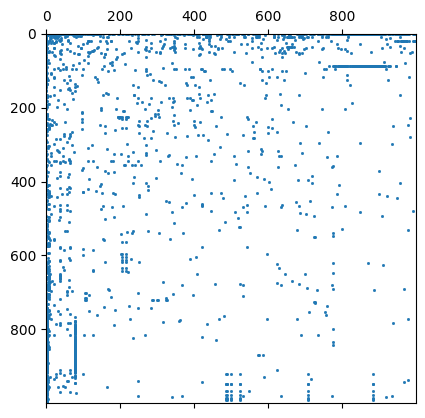

In [6]:
import numpy as np
import matplotlib.pyplot as plt
adj = np.load('./../data/postprocessing/adjacency.npy')
plt.spy(adj, markersize=1)

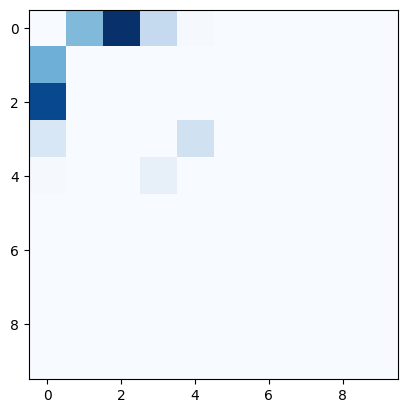

In [9]:
plt.imshow(adj[:10, :10], cmap='Blues')